In [1]:
!mkdir -p ~/.kaggle

In [2]:
!cp kaggle.json ~/.kaggle/

In [4]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
brain-tumor-mri-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
import zipfile
zip_data = zipfile.ZipFile('/content/brain-tumor-mri-dataset.zip')
zip_data.extractall('/content')
zip_data.close()

In [5]:
### import basic packages to build CNN Model

import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout
from keras.callbacks import EarlyStopping

In [6]:
# Generate dataset

train_ds = keras.utils.image_dataset_from_directory(directory = '/content/Training',labels = 'inferred',label_mode = 'int',batch_size=32,image_size=(256,256))

Found 5712 files belonging to 4 classes.


In [7]:
test_ds = keras.utils.image_dataset_from_directory(directory = '/content/Testing',labels = 'inferred',label_mode = 'int',batch_size = 32,image_size=(256,256))

Found 1311 files belonging to 4 classes.


In [8]:
#### NORMALIZATION

def process(image,label):
  image = tf.cast(image/255.,tf.float32)
  return image,label

train_ds = train_ds.map(process)
test_ds = test_ds.map(process)

In [15]:
#Building CNN model
model = keras.models.Sequential([
                         keras.layers.Conv2D(filters=64, kernel_size=3, strides=(1,1), padding='valid',activation= 'relu', input_shape=[256,256,3]),
                         keras.layers.MaxPooling2D(pool_size=(2,2)),
                         keras.layers.Conv2D(filters=128, kernel_size=3, strides=(2,2), padding='same', activation='relu'),
                         keras.layers.MaxPooling2D(pool_size=(2,2)),
                         keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2,2), padding='same', activation='relu'),
                         keras.layers.MaxPooling2D(pool_size=(2,2)),
                         keras.layers.Flatten(),
                         keras.layers.Dense(units=128, activation='relu'),
                         keras.layers.Dropout(0.25),
                         keras.layers.Dense(units=256, activation='relu'),
                         keras.layers.Dropout(0.5),
                         keras.layers.Dense(units=256, activation='relu'),
                         keras.layers.Dropout(0.25),
                         keras.layers.Dense(units=128, activation='relu'),
                         keras.layers.Dropout(0.10),
                         keras.layers.Dense(units=10, activation='softmax')
                         ])

Training and Results

To train the network, we have to compile it.

The compilation processes involve specifying the following items:

Loss function:

A method that quantifies ‘how well’ a machine learning model performs. The quantification is an output(cost) based on a set of inputs, which are referred to as parameter values. The parameter values are used to estimate a prediction, and the ‘loss’ is the difference between the predictions and the actual values.

Optimization Algorithm:

An optimizer within a neural network is an algorithmic implementation that facilitates the process of gradient descent within a neural network by minimizing the loss values provided via the loss function. To reduce the loss, it is paramount the values of the weights within the network are selected appropriately.

Learning Rate:

An integral component of a neural network implementation detail as it’s a factor value that determines the level of updates that are made to the values of the weights of the network. Learning rate is a type of hyperparameter.

We can also provide a summary of the network to have more insight into the layer composition of the network by running the model.summary() function.

In [16]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 127, 127, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 32, 32, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 16, 16, 64)        73792     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 8, 8, 64)         

In [17]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

In [18]:
callback = EarlyStopping(monitor = 'val_loss',min_delta = 0.01,patience = 50,verbose = 1,mode = 'auto',baseline = None,restore_best_weights = False,start_from_epoch =0)

In [19]:
history = model.fit(train_ds,batch_size = 128,epochs = 1000,validation_data= test_ds,callbacks = callback)

Epoch 1/1000
179/179 [==============================] - 26s 98ms/step - loss: 1.0400 - accuracy: 0.5350 - val_loss: 0.7245 - val_accuracy: 0.7109
Epoch 2/1000
179/179 [==============================] - 17s 94ms/step - loss: 0.5655 - accuracy: 0.7686 - val_loss: 0.5544 - val_accuracy: 0.7605
Epoch 3/1000
179/179 [==============================] - 16s 86ms/step - loss: 0.3921 - accuracy: 0.8578 - val_loss: 0.5049 - val_accuracy: 0.8192
Epoch 4/1000
179/179 [==============================] - 17s 92ms/step - loss: 0.2785 - accuracy: 0.8993 - val_loss: 0.3444 - val_accuracy: 0.8520
Epoch 5/1000
179/179 [==============================] - 15s 85ms/step - loss: 0.2334 - accuracy: 0.9181 - val_loss: 0.3249 - val_accuracy: 0.8627
Epoch 6/1000
179/179 [==============================] - 16s 85ms/step - loss: 0.1904 - accuracy: 0.9354 - val_loss: 0.2541 - val_accuracy: 0.8955
Epoch 7/1000
179/179 [==============================] - 17s 91ms/step - loss: 0.1696 - accuracy: 0.9410 - val_loss: 0.4021 -

179/179 - 11s - loss: 0.0019 - accuracy: 0.9993 - 11s/epoch - 60ms/step


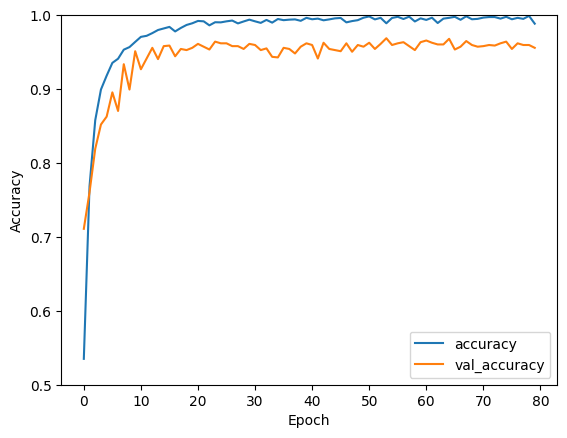

In [25]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(train_ds, verbose=2)